## Evaluation

The result is evaluated on the Mean Absolute Error (MAE) between the predicted return and the observed target. The formula is given by:

$$
MAE = \frac{1}{n}\sum_{i=1}{n}|y_i - x_i|
$$

Where:
- n is the total number of data points.
- y_i is the predicted value for data point i.
- x_i is the observed value for data point i.

In [3]:
import warnings

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.width', 1000)

warnings.filterwarnings("ignore")

data = pd.read_csv('../data/raw_kaggle/train.csv')

# Baseline Score:

Baseline is achieved by assign the target mean of each stock in the test set as the predition.

In [4]:
def reduce_memory_usage(df):
    print("Memory Usage Before Optimization:")
    print(df.memory_usage(deep=True).sum() / (1024 ** 2), "MB")

    # Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype

        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
                    
    # Display the memory usage after optimization
    print("\nMemory Usage After Optimization:")
    print(df.memory_usage(deep=True).sum() / (1024 ** 2), "MB")
    return df

In [6]:
from sklearn.metrics import mean_absolute_error

simple_mapping = {1: 0.1, 0: 0, -1: -0.1}

# Prepare data
date_col, target_col = 'date_id', 'target'
data_new = reduce_memory_usage(data[data[date_col]<=120])
X = data_new.drop(columns=[target_col])
y = data_new[target_col]
groups = data_new[date_col]

baseline_scores_mean = []
baseline_scores_zero = []
baseline_scores_simple = []

# Split test data
len_group = groups.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group*0.2), n_splits=4)
for i_other, i_test in gts.split(X, y, groups):
    print("Other index:", i_other, "TEST index:", i_test)
    X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]

    # predict by mean of each stock
    df_test = X_test.copy()
    df_test['y_true'] = y_test
    baseline = df_test.groupby('stock_id').y_true.mean().reset_index().rename(columns={'y_true': 'y_pred_mean'})
    df_test = pd.merge(df_test, baseline, how='left', on='stock_id')

    # predict by all zeros
    df_test['y_pred_zero'] = 0

    # predict by simple guess according to imbalance flag
    df_test['y_pred_simple'] = df_test['imbalance_buy_sell_flag'].map(simple_mapping)

    baseline_scores_mean.append(mean_absolute_error(df_test['y_true'], df_test['y_pred_mean']))
    baseline_scores_zero.append(mean_absolute_error(df_test['y_true'], df_test['y_pred_zero']))
    baseline_scores_simple.append(mean_absolute_error(df_test['y_true'], df_test['y_pred_simple']))

print('baseline prediction by mean:')
print(baseline_scores_mean, 'mean:', np.mean(baseline_scores_mean), 'std:', np.std(baseline_scores_mean))
print('baseline prediction by zeros:')
print(baseline_scores_zero, 'mean:', np.mean(baseline_scores_zero), 'std:', np.std(baseline_scores_zero))
print('baseline prediction by simple guess:')
print(baseline_scores_simple, 'mean:', np.mean(baseline_scores_simple), 'std:', np.std(baseline_scores_simple))

Memory Usage Before Optimization:
249.84978008270264 MB

Memory Usage After Optimization:
156.00292491912842 MB
Other index: [      0       1       2 ... 1002262 1002263 1002264] TEST index: [1002265 1002266 1002267 ... 1262302 1262303 1262304]
Other index: [  10505   10506   10507 ... 1013097 1013098 1013099] TEST index: [1013100 1013101 1013102 ... 1273137 1273138 1273139]
Other index: [  21010   21011   21012 ... 1023932 1023933 1023934] TEST index: [1023935 1023936 1023937 ... 1283972 1283973 1283974]
Other index: [  31515   31516   31517 ... 1034767 1034768 1034769] TEST index: [1034770 1034771 1034772 ... 1294807 1294808 1294809]
baseline prediction by mean:
[6.904287, 6.9071627, 7.012034, 6.8835454] mean: 6.926757 std: 0.05007056
baseline prediction by zeros:
[6.90983906116069, 6.9130083554855695, 7.018535942617627, 6.890506765223011] mean: 6.932972531121725 std: 0.0501452001727252
baseline prediction by simple guess:
[6.909906444691122, 6.913098134846343, 7.01860804010989, 6.89

# Model Scores:

## XGBoost

In [8]:
import pickle
import numpy as np

with open('../result/xgboost/xgboost_scores.pkl', 'rb') as file:
    scores_xgb = pickle.load(file)
with open('../result/xgboost/xgboost_pred_results.pkl', 'rb') as file:
    pred_results_xgb = pickle.load(file)
with open('../result/xgboost/xgboost_best_models.pkl', 'rb') as file:
    best_models_xgb = pickle.load(file)

test_scores_xgb = scores_xgb['Test_Scores']
best_model_xgb = best_models_xgb[-1]
print(test_scores_xgb)
print('mean MAE:', np.mean(test_scores_xgb), 'std MAE:', np.std(test_scores_xgb))

[08:56:07] WARNING: D:\bld\xgboost-split_1693020860727\work\src\learner.cc:553: 
  If you are loading a serialized model (like pickle in Python, RDS in R) generated by
  older XGBoost, please export the model by calling `Booster.save_model` from that version
  first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html

  for more details about differences between saving model and serializing.

[6.73876265 6.74234162 6.74128729 6.74073149]
mean MAE: 6.740780763151302 std MAE: 0.0013007745099942825


## Lasso Reduced Features:

In [9]:
with open('../result/linear_reduced_feature/lasso_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_lasso = pickle.load(file)
with open('../result/linear_reduced_feature/lasso_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_lasso = pickle.load(file)

print(test_scores_lasso)
print('mean MAE:', np.mean(test_scores_lasso), 'std MAE:', np.std(test_scores_lasso))

[6.7354542  6.7353624  6.73541976 6.73531435]
mean MAE: 6.735387677419143 std MAE: 5.355157758185661e-05


## Ridge RF

In [10]:
with open('../result/linear_reduced_feature/ridge_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_ridge = pickle.load(file)
with open('../result/linear_reduced_feature/ridge_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_ridge = pickle.load(file)

print(test_scores_ridge)
print('mean MAE:', np.mean(test_scores_ridge), 'std MAE:', np.std(test_scores_ridge))

[6.75691924 6.75678804 6.75987626 6.75729838]
mean MAE: 6.757720479085643 std MAE: 0.001258666177864995


## XGB Reduced Features

In [11]:
with open('../result/xgboost_reduced_feature/xgb_reduced_feature_test_scores.pkl', 'rb') as file:
    test_scores_rf_xgb = pickle.load(file)
with open('../result/xgboost_reduced_feature/xgb_reduced_feature_pred_results.pkl', 'rb') as file:
    pred_results_rf_xgb = pickle.load(file)

print(test_scores_rf_xgb)
print('mean MAE:', np.mean(test_scores_rf_xgb), 'std MAE:', np.std(test_scores_rf_xgb))

[6.74028892 6.73927359 6.73884638 6.73712802]
mean MAE: 6.738884228337913 std MAE: 0.0011413218275947614


## Mean Std

Text(19.76795402381798, 0.5, 'Mean (Std) of Mean Absolute Error')

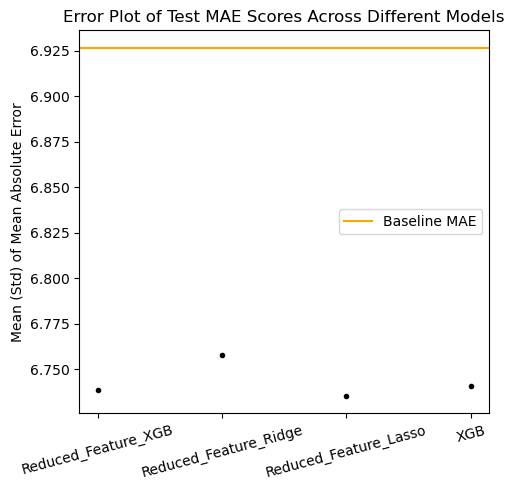

In [17]:
import matplotlib.pylab as plt

means = [np.mean(test_scores_rf_xgb),
         np.mean(test_scores_ridge),
         np.mean(test_scores_lasso),
         np.mean(test_scores_xgb)]
std_devs = [np.std(test_scores_rf_xgb),
            np.std(test_scores_ridge),
            np.std(test_scores_lasso),
            np.std(test_scores_xgb)]
baseline_mae_score = 6.926757

labels = ['Reduced_Feature_XGB', 'Reduced_Feature_Ridge', 'Reduced_Feature_Lasso', 'XGB']

plt.figure(figsize=(5, 5))
plt.errorbar(labels, means, yerr=std_devs, fmt='.k')
plt.axhline(y=baseline_mae_score, color='orange', linestyle='-', label='Baseline MAE')
plt.xticks(rotation=15)
plt.title("Error Plot of Test MAE Scores Across Different Models")
plt.tight_layout()
plt.legend()
plt.savefig('../figures/evaluation/error_plot_test_scores.png', dpi=300, bbox_inches='tight')
plt.ylabel("Mean (Std) of Mean Absolute Error")

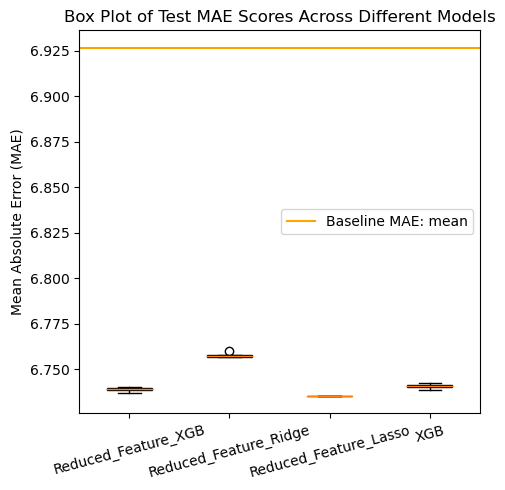

In [16]:
data = [test_scores_rf_xgb, test_scores_ridge, test_scores_lasso, test_scores_xgb]

plt.figure(figsize=(5, 5))
plt.boxplot(data, patch_artist=True)
plt.axhline(y=baseline_mae_score, color='orange', linestyle='-', label='Baseline MAE: mean')

plt.xticks(range(1, len(labels) + 1), labels)
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Box Plot of Test MAE Scores Across Different Models')
plt.xticks(rotation=15)
plt.legend()
plt.tight_layout()
plt.savefig('../figures/evaluation/box_plot_test_scores.png', dpi=300, bbox_inches='tight')
plt.show()

# Scatter Plots
For each model, we plot the predictions using 4-th fold results.

In [28]:
predictions = pd.DataFrame({'target': y_test.values.reshape(-1),
                            'pred_xgb_reduced_feature': pred_results_rf_xgb[-1].values.reshape(-1),
                            'pred_lasso_reduced_feature': pred_results_lasso[-1].values.reshape(-1),
                            'pred_ridge_reduced_feature': pred_results_ridge[-1].values.reshape(-1),
                            'pred_xgboost': pred_results_xgb[-1]})

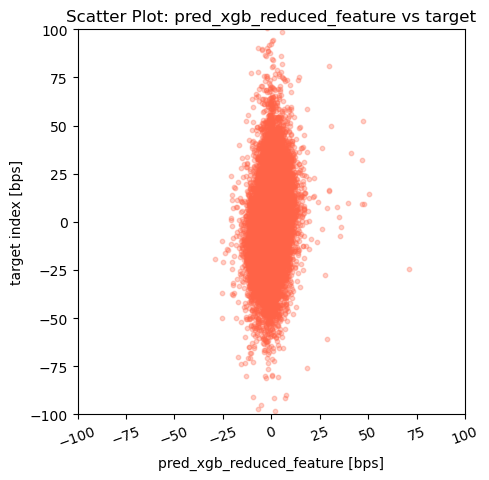

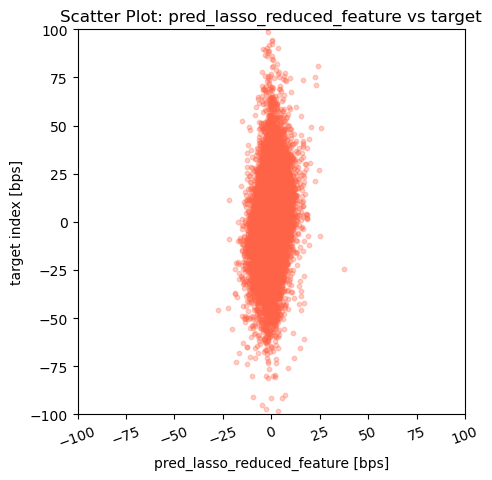

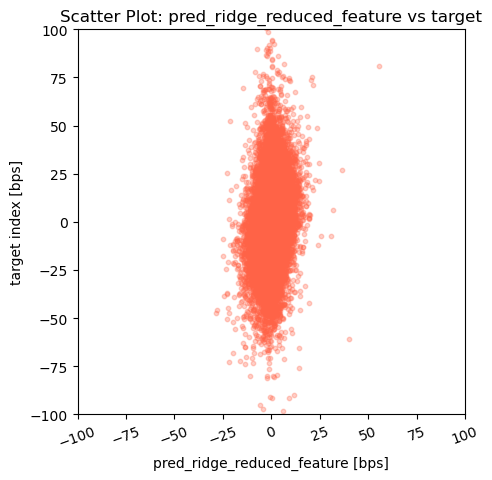

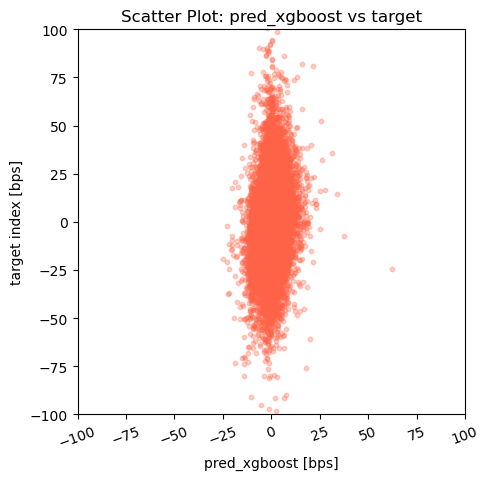

In [33]:
for pred in ['pred_xgb_reduced_feature', 'pred_lasso_reduced_feature',
             'pred_ridge_reduced_feature', 'pred_xgboost']:
    predictions.plot.scatter(pred, 'target', figsize=(5,5), color='tomato', alpha=0.3, s=10)
    plt.xlim([-100, 100])  
    plt.ylim([-100, 100])  
    plt.xticks(rotation=20)
    plt.xlabel(f'{pred} [bps]')
    plt.ylabel('target index [bps]')
    plt.title(f'Scatter Plot: {pred} vs target')
    plt.savefig(f'../figures/evaluation/scatter_plot_{pred}_vs_target.png', dpi=300, bbox_inches='tight')
    plt.show()

# Feature Importances

In [ ]:
import pickle

with open('../data/preprocessed/train_val_dataset.pkl', 'rb') as file:
    train_val_dataset = pickle.load(file)
    
with open('../data/preprocessed/test_dataset.pkl', 'rb') as file:
    test_dataset = pickle.load(file)

X_other, y_other, groups_other = train_val_dataset['X_other'], train_val_dataset['y_other'], train_val_dataset['groups_other']
X_test, y_test, groups_test, submission_id = test_dataset['X_test'], test_dataset['y_test'], test_dataset['groups_test'], test_dataset['submission_id']

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info)

# collect which encoder to use on each feature
onehot_ftrs = ['imbalance_buy_sell_flag', 'stock_id']
std_ftrs = ['seconds_in_bucket', 'imbalance_size', 'reference_price', 'matched_size', 
            'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 
            'wap', 'lagged_target_1d_0', 'lagged_target_1d_10', 'lagged_target_1d_20', 
            'lagged_target_1d_30', 'lagged_target_1d_40', 'lagged_target_1d_50', 
            'lagged_target_1d_60', 'lagged_target_1d_70', 'lagged_target_1d_80', 
            'lagged_target_1d_90', 'lagged_target_1d_100', 'lagged_target_1d_110', 
            'lagged_target_1d_120', 'lagged_target_1d_130', 'lagged_target_1d_140', 
            'lagged_target_1d_150', 'lagged_target_1d_160', 'lagged_target_1d_170', 
            'lagged_target_1d_180', 'lagged_target_1d_190', 'lagged_target_1d_200', 
            'lagged_target_1d_210', 'lagged_target_1d_220', 'lagged_target_1d_230', 
            'lagged_target_1d_240', 'lagged_target_1d_250', 'lagged_target_1d_260', 
            'lagged_target_1d_270', 'lagged_target_1d_280', 'lagged_target_1d_290', 
            'lagged_target_1d_300', 'lagged_target_1d_310', 'lagged_target_1d_320', 
            'lagged_target_1d_330', 'lagged_target_1d_340', 'lagged_target_1d_350', 
            'lagged_target_1d_360', 'lagged_target_1d_370', 'lagged_target_1d_380', 
            'lagged_target_1d_390', 'lagged_target_1d_400', 'lagged_target_1d_410', 
            'lagged_target_1d_420', 'lagged_target_1d_430', 'lagged_target_1d_440', 
            'lagged_target_1d_450', 'lagged_target_1d_460', 'lagged_target_1d_470', 
            'lagged_target_1d_480', 'lagged_target_1d_490', 'lagged_target_1d_500', 
            'lagged_target_1d_510', 'lagged_target_1d_520', 'lagged_target_1d_530', 
            'lagged_target_1d_540', 'volume', 'mid_price', 'liquidity_imbalance', 
            'matched_imbalance', 'size_imbalance', 'reference_price_far_price_imb', 
            'reference_price_near_price_imb', 'reference_price_ask_price_imb', 
            'reference_price_bid_price_imb', 'reference_price_wap_imb', 'far_price_near_price_imb', 
            'far_price_ask_price_imb', 'far_price_bid_price_imb', 'far_price_wap_imb', 
            'near_price_ask_price_imb', 'near_price_bid_price_imb', 'near_price_wap_imb', 
            'ask_price_bid_price_imb', 'ask_price_wap_imb', 'bid_price_wap_imb', 'price_spread', 
            'price_pressure', 'market_urgency', 'depth_pressure', 'all_prices_mean', 
            'all_sizes_mean', 'all_prices_std', 'all_sizes_std', 'all_prices_skew', 
            'all_sizes_skew', 'all_prices_kurt', 'all_sizes_kurt', 'dow', 'seconds', 'minute']

# collect all the encoders
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])
prep = Pipeline(steps=[('preprocessor', preprocessor)])

len_group_other = groups_other.nunique()
gts = GroupTimeSeriesSplit(test_size=int(len_group_other*0.25), n_splits=4)

for i_train, i_val in gts.split(X_other, y_other, groups_other):
    print("\t Train index:", i_train, "Val index:", i_val)
    print("\t Train size:", len(i_train), "Val size:", len(i_val))
    X_train, y_train, groups_train = X_other.iloc[i_train], y_other.iloc[i_train], groups_other.iloc[i_train]
    X_val, y_val, groups_val = X_other.iloc[i_val], y_other.iloc[i_val], groups_other.iloc[i_val]
    
    X_train_preprocessed = prep.fit_transform(X_train)
    feature_names = prep.get_feature_names_out()
    X_test_preprocessed = prep.transform(X_test)
    df_test = pd.DataFrame(data = X_test_preprocessed, columns = feature_names, index=y_test.index)

	 Train index: [     0      1      2 ... 743181 743182 743183] Val index: [ 743184  743185  743186 ... 1002231 1002232 1002233]
	 Train size: 743184 Val size: 259050
	 Train index: [ 10505  10506  10507 ... 753961 753962 753963] Val index: [ 753964  753965  753966 ... 1013066 1013067 1013068]
	 Train size: 743459 Val size: 259105
	 Train index: [ 21010  21011  21012 ... 764741 764742 764743] Val index: [ 764744  764745  764746 ... 1023901 1023902 1023903]
	 Train size: 743734 Val size: 259160
	 Train index: [ 31515  31516  31517 ... 775521 775522 775523] Val index: [ 775524  775525  775526 ... 1034736 1034737 1034738]
	 Train size: 744009 Val size: 259215
